In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm

from pseudobatch import pseudobatch_transform
from pseudobatch.datasets import load_standard_fedbatch

/Users/s143838/.virtualenvs/fedbatch-data-correction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


In [2]:
fedbatch_df = load_standard_fedbatch()

In [3]:
# Calculating the concentrations
fedbatch_df['c_Biomass'] = fedbatch_df['m_Biomass'] /  fedbatch_df['v_Volume']
fedbatch_df['c_Glucose'] = fedbatch_df['m_Glucose'] /  fedbatch_df['v_Volume']
fedbatch_df['c_CO2'] = fedbatch_df['m_CO2'] /  fedbatch_df['v_Volume']
fedbatch_df

,Kc_s,mu_max,Yxs,Yxp,Yxco2,F0,mu0,s_f,sample_volume,timestamp,...,m_Biomass,m_Product,m_CO2,v_Volume,v_Feed_accum,c_Glucose,c_Biomass,c_Product,c_CO2,mu_true
0,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,0.00000,...,500.000000,0.000000,0.000000,1000.000000,0.000000,0.075000,0.500000,0.000000,0.000000,0.100000
1,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,0.06006,...,503.012039,2.474421,0.136124,1000.055765,0.055765,0.075000,0.502984,0.002474,0.000136,0.100000
2,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,0.12012,...,506.042223,4.963748,0.273068,1000.111865,0.111865,0.075000,0.505986,0.004963,0.000273,0.100000
3,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,0.18018,...,509.090661,7.468071,0.410837,1000.168303,0.168303,0.075000,0.509005,0.007467,0.000411,0.100000
4,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,0.24024,...,512.157463,9.987480,0.549436,1000.225082,0.225082,0.075000,0.512042,0.009985,0.000549,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,59.75976,...,37998.651234,31137.022525,1712.925452,894.675032,994.675032,0.074972,42.472015,34.802606,1.914578,0.099975
1007,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,59.81982,...,38227.530636,31325.049299,1723.269275,898.912986,998.912986,0.075028,42.526397,34.847699,1.917059,0.100025
1008,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,59.87988,...,38457.806226,31514.223056,1733.676196,903.176469,1003.176469,0.075049,42.580611,34.892653,1.919532,0.100043
1009,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,59.93994,...,38689.506981,31704.567601,1744.147525,907.465636,1007.465636,0.074992,42.634680,34.937486,1.921998,0.099993


## Do pseudo batch transformation

In [6]:
species_to_correct = ["c_Biomass", "c_Glucose", "c_CO2"]
concentration_in_feed = [0, 93.75, 0]

for (species, conc) in zip(species_to_correct, concentration_in_feed):
    species_name = species.split('_')[1]
    fedbatch_df['pseudo_'+species_name] = pseudobatch_transform(
                measured_concentration=fedbatch_df[species].to_numpy(),
                reactor_volume=fedbatch_df['v_Volume'].to_numpy(),
                accumulated_feed=fedbatch_df['v_Feed_accum'].to_numpy(),
                concentration_in_feed=conc,
                sample_volume=fedbatch_df['sample_volume'].fillna(0).to_numpy() # the sample volume column contains nan when at times where no sample was taken
            )        
fedbatch_df

,Kc_s,mu_max,Yxs,Yxp,Yxco2,F0,mu0,s_f,sample_volume,timestamp,...,v_Volume,v_Feed_accum,c_Glucose,c_Biomass,c_Product,c_CO2,mu_true,pseudo_Biomass,pseudo_Glucose,pseudo_CO2
0,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,0.00000,...,1000.000000,0.000000,0.075000,0.500000,0.000000,0.000000,0.100000,0.500000,0.075000,0.000000
1,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,0.06006,...,1000.055765,0.055765,0.075000,0.502984,0.002474,0.000136,0.100000,0.503012,0.069776,0.000136
2,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,0.12012,...,1000.111865,0.111865,0.075000,0.505986,0.004963,0.000273,0.100000,0.506042,0.064521,0.000273
3,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,0.18018,...,1000.168303,0.168303,0.075000,0.509005,0.007467,0.000411,0.100000,0.509091,0.059234,0.000411
4,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,0.24024,...,1000.225082,0.225082,0.075000,0.512042,0.009985,0.000549,0.100000,0.512157,0.053915,0.000549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,59.75976,...,894.675032,994.675032,0.074972,42.472015,34.802606,1.914578,0.099975,196.926223,-340.584691,8.877156
1007,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,59.81982,...,898.912986,998.912986,0.075028,42.526397,34.847699,1.917059,0.100025,198.112379,-342.641813,8.930762
1008,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,59.87988,...,903.176469,1003.176469,0.075049,42.580611,34.892653,1.919532,0.100043,199.305772,-344.711493,8.984695
1009,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,0.0,59.93994,...,907.465636,1007.465636,0.074992,42.634680,34.937486,1.921998,0.099993,200.506550,-346.794005,9.038963


<AxesSubplot:xlabel='timestamp', ylabel='pseudo_Biomass'>

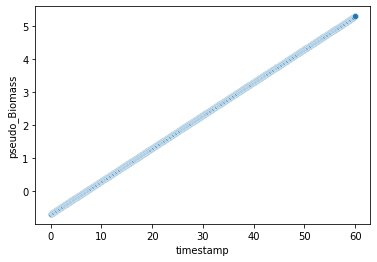

In [7]:
sns.scatterplot( x=fedbatch_df['timestamp'], y=fedbatch_df['pseudo_Biomass'].transform(np.log))

<AxesSubplot:xlabel='timestamp', ylabel='pseudo_Glucose'>

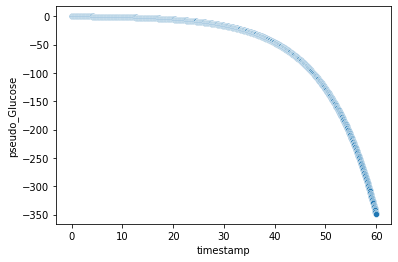

In [8]:
sns.scatterplot( x=fedbatch_df['timestamp'], y=fedbatch_df['pseudo_Glucose'])